In [2]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

We will generate fake data, that will simulate dataset of 100 outputs from 200 dimensional linear model along with appropriate predictors. Our goal will be estimation of the parameters of the model.

In [3]:
data_genetator = CmdStanModel(stan_file = 'generate_data.stan')
print(data_genetator.code())

INFO:cmdstanpy:found newer exe file, not recompiling


transformed data {
    int<lower=0> M = 200;
    int<lower=0> N = 100;
    real alpha = 3;
    real sigma =1;
    real<lower=0, upper=1> sig_prob = 0.05;
}

generated quantities {
    matrix[M, N] X;
    array[N] real y;


vector[M] beta;
for (m in 1:M) {
    if (bernoulli_rng(sig_prob))
        if (bernoulli_rng(0.5))
            beta[m] = normal_rng(10, 1);
        else
            beta[m] = normal_rng(-10, 1);
    else
        beta[m] = normal_rng(0, 0.25);
}

for (n in 1:N){
    for (m in 1:M)
        X[m, n] = normal_rng(0, 1);
        
    y[n] = normal_rng(X[1:M, n]' * beta + alpha, sigma);
}
}


In [4]:
I= 5#number of letters in name
N= 9#number of letters in surname
DoB= 1504#date of birth
seed=int(DoB*1e4+100*I+N)
print(seed)
generated_data = data_genetator.sample(chains=1, iter_sampling=1, iter_warmup=0, fixed_param=True,seed=seed)

INFO:cmdstanpy:CmdStan start processing
ERROR:cmdstanpy:Error in progress bar initialization:
	IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Disabling progress bars for this session
Exception ignored in: <function tqdm.__del__ at 0x7fb4ff281790>
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/DataAnalytics/lib/python3.8/site-packages/tqdm/std.py", line 1122, in __del__
    self.close()
  File "/usr/local/anaconda3/envs/DataAnalytics/lib/python3.8/site-packages/tqdm/notebook.py", line 261, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm' object has no attribute 'sp'


15040509
                                                                                

INFO:cmdstanpy:CmdStan done processing.


### Coefficients of linear model
Only few of beta coefficients are significantly greater than 0.





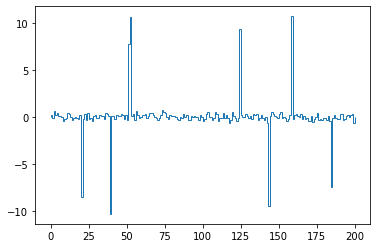

In [5]:
beta_s = generated_data.stan_variable('beta')
plt.stairs(generated_data.stan_variable('beta')[0])
plt.show()

In [6]:
print(generated_data.stan_variable('beta'))

[[ 2.19547e-01 -7.46999e-02  6.21745e-01  1.52566e-01  3.80492e-01
   5.60602e-02  9.54395e-02 -3.85940e-02 -3.86920e-01 -2.22970e-01
  -7.27304e-02  3.81385e-01  3.50567e-01  3.95452e-02 -3.31874e-01
  -8.99505e-02 -5.62910e-02 -1.32221e-01 -2.08939e-01  1.98789e-01
  -8.47458e+00 -2.02807e-01  2.94566e-01 -3.65829e-01  4.43084e-01
  -2.07485e-01 -1.49117e-01 -4.40960e-01  1.48499e-01  1.85852e-01
  -1.12463e-01 -1.22078e-01  2.18393e-01  1.24866e-01  8.62413e-02
  -1.75493e-01  4.40759e-01  2.96510e-01  1.21604e-01 -1.03132e+01
   1.22047e-01  1.07357e-01 -2.42905e-01  2.18540e-01  7.18023e-02
   8.74458e-02  3.03271e-01  1.59237e-01 -2.45179e-01  1.59365e-01
  -3.00984e-01  7.80135e+00  1.06607e+01  6.20517e-02  3.28990e-01
  -3.09332e-01  5.88862e-01  2.33519e-01 -7.54537e-02  4.22952e-02
   2.07526e-01  1.86791e-01  3.12748e-01 -1.55470e-01  1.17414e-01
   3.67106e-01  4.33451e-01  1.62076e-01  1.06738e-03 -1.47197e-01
  -3.35456e-01 -7.25571e-02  1.77811e-01  7.23227e-01  4.83284

This is an issue called sparsity. We will try to exploit that when infering the results via changing the prior structure.



## Model 1 - uniform prior for beta


In [7]:
model_uniform = CmdStanModel(stan_file = 'model1.stan')
print(model_uniform.code())
data_for_inference = {'N':100,
                      'M':200,
                      'X':generated_data.stan_variable('X')[0],
                      'y':generated_data.stan_variable('y')[0]
                      }

INFO:cmdstanpy:found newer exe file, not recompiling


data {
    int<lower=1> N; // Number of data
    int<lower=1> M; // Number of covariates
    matrix[M, N] X;
    array[N] real y;
}

parameters {
    vector[M] beta;
    real alpha;
    real<lower=0> sigma;
}

model {
    // No priors on the slopes
    alpha ~ normal(0, 2);
    sigma ~ normal(0, 2);
    
    y ~ normal(X' * beta + alpha, sigma);
}


In [9]:
fit_unf = model_uniform.sample(data=data_for_inference,seed=seed)
print(fit_unf.diagnose())


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing


Processing csv files: /var/folders/3c/q2s2z4v92bx59zp2nvycr10c0000gn/T/tmpk9f009yw/model1-20220404165128_1.csv, /var/folders/3c/q2s2z4v92bx59zp2nvycr10c0000gn/T/tmpk9f009yw/model1-20220404165128_2.csv, /var/folders/3c/q2s2z4v92bx59zp2nvycr10c0000gn/T/tmpk9f009yw/model1-20220404165128_3.csv, /var/folders/3c/q2s2z4v92bx59zp2nvycr10c0000gn/T/tmpk9f009yw/model1-20220404165128_4.csv

Checking sampler transitions treedepth.
3924 of 4000 (98.10%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
76 of 4000 (1.90%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - s

### Task 1. Evaluating model

- Analyse the diagnosis of model. What sampling issues occured?
- For each fitted beta coefficient plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with true values of beta.
- Substract true values from fitted betas and make the same plot (residues)

In [64]:
def draw_quan(draws_fit_unf1):
    draws_fit_unf1=fit_unf.draws_pd()
    draws_fit_unf_iloc1=draws_fit_unf1.iloc[:, 0:200]
    print((draws_fit_unf_iloc1.shape))

    l=[]
    x=[]
    mini=[]
    maxi=[]
    quantiles = {5:[], 25:[], 50: [], 75: [], 95: []}
    i = 0
    for col in draws_fit_unf_iloc1:
        beta = draws_fit_unf_iloc1[col]
        beta = np.array(beta.tolist())
        l.append(beta)
        x.append(np.linspace(i,i,num=len(beta)))

        mini.append(np.quantile(beta,0))
        maxi.append(np.quantile(beta,1))
        quantiles[5].append(np.quantile(beta,0.05))
        quantiles[25].append(np.quantile(beta,0.25))
        quantiles[50].append(np.quantile(beta,0.50))
        quantiles[75].append(np.quantile(beta,0.75))
        quantiles[95].append(np.quantile(beta,0.95))

        i += 1

    plt.figure(figsize=(10,5))
    plt.plot(x,l,'o')
    plt.plot(mini,'k')
    plt.plot(maxi,'k')

    for quant in quantiles:
        plt.plot(quantiles[quant],'k')
    plt.show()
    
    return x,l, beta

(4000, 200)


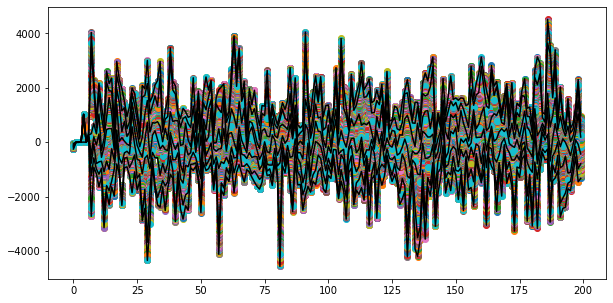

In [65]:
x, l, beta = draw_quan(fit_unf)

In [56]:
def draw_dub(x, l, beta):
    plt.figure(figsize=(10,5))
    beta_s_list = beta_s.tolist()
    for i in range(len(l)):
        beta[i] = beta[i] - beta_s_list[0][i]

    plt.plot(x,beta[:200],'o')
    plt.show()

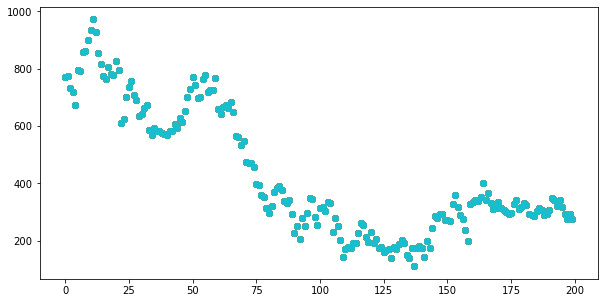

In [57]:
draw_dub(x, l, beta)

## Model 2 - Narrow weakly informative prior.

We try to improve sampling by regularizing the search space with normal priors. This is prior used in ridge regression (but here is the bayesian context)



In [58]:
model_reg = CmdStanModel(stan_file = 'model2.stan')
fit_reg = model_reg.sample(data=data_for_inference,seed=seed)
print(fit_reg.diagnose())


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing


Processing csv files: /var/folders/3c/q2s2z4v92bx59zp2nvycr10c0000gn/T/tmpk9f009yw/model2-20220404174136_1.csv, /var/folders/3c/q2s2z4v92bx59zp2nvycr10c0000gn/T/tmpk9f009yw/model2-20220404174136_2.csv, /var/folders/3c/q2s2z4v92bx59zp2nvycr10c0000gn/T/tmpk9f009yw/model2-20220404174136_3.csv, /var/folders/3c/q2s2z4v92bx59zp2nvycr10c0000gn/T/tmpk9f009yw/model2-20220404174136_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [59]:
print(model_reg.code())

data {
    int<lower=1> N; // Number of data
    int<lower=1> M; // Number of covariates
    matrix[M, N] X;
    array[N] real y;
}

parameters {
    vector[M] beta;
    real alpha;
    real<lower=0> sigma;
}

model {
    // Strongly regularizing priors on the slopes
    beta ~ normal(0, 1);
    alpha ~ normal(0, 2);
    sigma ~ normal(0, 2);
    
    y ~ normal(X' * beta + alpha, sigma);
}


### Task 2. Evaluating model

- Analyse the diagnosis of model. Are the sampling problems solved
- For each fitted beta coefficient plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with true values of beta.
- Substract true values from fitted betas and make the same plot (residues)

(4000, 200)


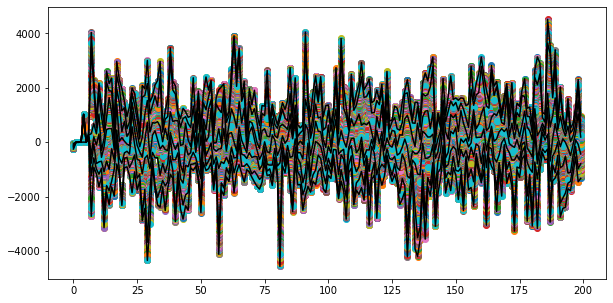

In [67]:
x, l, beta = draw_quan(fit_reg)

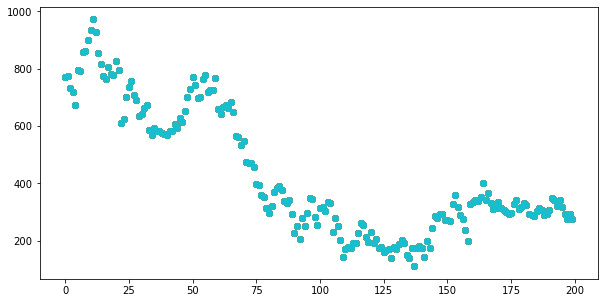

In [68]:
draw_dub(x, l, beta)

## Model 3 - Sparsity enforcing prior
We will now try to enforce shrinking of small parameters using a Laplace prior. This is a prior that is used in Lasso regression. (but here is the bayesian context)



In [70]:
model_lap = CmdStanModel(stan_file = 'model3.stan')
fit_lap = model_lap.sample(data=data_for_inference,seed=seed,adapt_delta=0.99,max_treedepth=12) #sampling problematic some parameters have to be adjusted
print(fit_lap.diagnose())



INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing


Processing csv files: /var/folders/3c/q2s2z4v92bx59zp2nvycr10c0000gn/T/tmpk9f009yw/model3-20220404174426_1.csv, /var/folders/3c/q2s2z4v92bx59zp2nvycr10c0000gn/T/tmpk9f009yw/model3-20220404174426_2.csv, /var/folders/3c/q2s2z4v92bx59zp2nvycr10c0000gn/T/tmpk9f009yw/model3-20220404174426_3.csv, /var/folders/3c/q2s2z4v92bx59zp2nvycr10c0000gn/T/tmpk9f009yw/model3-20220404174426_4.csv

Checking sampler transitions treedepth.
256 of 4000 (6.40%) transitions hit the maximum treedepth limit of 12, or 2^12 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.04, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Effective sample size

### Task 3. Evaluating model

- Analyse the diagnosis of model. Are the sampling problems solved. Are there any new sampling issues?
- For each fitted beta coefficient plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with true values of beta.
- Substract true values from fitted betas and make the same plot (residues)

(4000, 200)


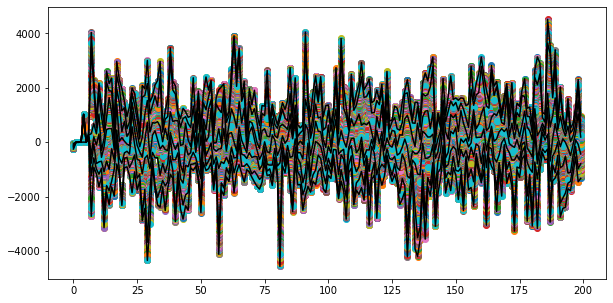

In [71]:
x, l, beta = draw_quan(fit_lap)

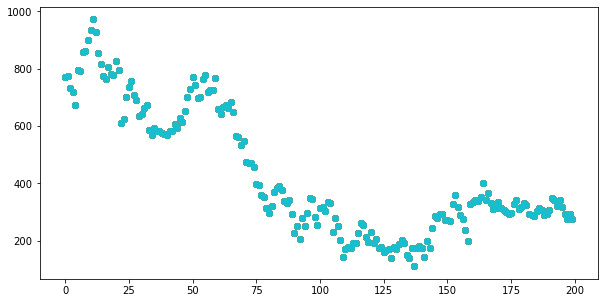

In [72]:
draw_dub(x, l, beta)